<a href="https://colab.research.google.com/github/MrLishu/PHM-Tongji/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), 'Mrlishu'))
if os.path.exists('/content'):
    os.chdir('/content')
    CODE_DIR = 'PHM-Tongji'
    if not os.path.exists(CODE_DIR):
        !git clone https://github.com/MrLishu/PHM-Tongji.git $CODE_DIR
    os.chdir(f'./{CODE_DIR}')

    # !git config --global user.email "2601165031@qq.com"
    # !git config --global user.name "MrLishu"

    # !pip install colabcode
    # from colabcode import ColabCode
    # ColabCode(port=10000)

    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from preprocess import cwt


raw_data_directory = r'../drive/PHM-Tongjidata/raw/PHM2010'
processed_data_directory = r'data/processed/PHM2010'

sampling_rate=50000

resample_number=1024
step=1

totalscale=256
wavename='morl'

c1_resample = np.load(r'data/processed/PHM2010/1d_1C1024_data_c1.npy')[:, :, 3:6].transpose(0, 2, 1)
c1_label = np.load(r'data/processed/PHM2010/2d_1C512_data_c1_labels.npy')[:, np.newaxis]
c4_resample = np.load(r'data/processed/PHM2010/1d_1C1024_data_c4.npy')[:, :, 3:6].transpose(0, 2, 1)
c4_label = np.load(r'data/processed/PHM2010/2d_1C512_data_c4_labels.npy')[:, np.newaxis]
c6_resample = np.load(r'data/processed/PHM2010/1d_1C1024_data_c6.npy')[:, :, 3:6].transpose(0, 2, 1)
c6_label = np.load(r'data/processed/PHM2010/2d_1C512_data_c6_labels.npy')[:, np.newaxis]
rs_rate = sampling_rate
c1_cwt = cwt(c1_resample, rs_rate, totalscale=totalscale, wavename=wavename, save=True, save_filepath=r'data/processed/PHM2010/cwt_1C1024_c1.npy')
c4_cwt = cwt(c4_resample, rs_rate, totalscale=totalscale, wavename=wavename, save=True, save_filepath=r'data/processed/PHM2010/cwt_1C1024_c4.npy')
cwt(c6_resample, rs_rate, totalscale=totalscale, wavename=wavename, save=True, save_filepath=r'data/processed/PHM2010/cwt_1C1024_c6.npy')
print('Completed')

Continuous wavelet transform... (315/315)
Continuous wavelet transform completed.
Data saved at data/processed/PHM2010/cwt_1C1024_c1.npy
Continuous wavelet transform... (315/315)
Continuous wavelet transform completed.
Data saved at data/processed/PHM2010/cwt_1C1024_c4.npy
Continuous wavelet transform... (315/315)
Continuous wavelet transform completed.
Data saved at data/processed/PHM2010/cwt_1C1024_c6.npy
Completed


In [19]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.data[index], self.label[index]

In [46]:
import pywt

class CWTTransform(object):
  def __init__(self, sampling_rate, totalscale=256, wavename='morl'):
    fc = pywt.central_frequency(wavename)
    cparam = 2 * fc * totalscale
    self.scales = cparam / np.arange(totalscale, 0, -1)
    self.wavename = wavename
    self.sampling_rate = sampling_rate

  def __call__(self, signal):
    cwtmatr, frequencies = pywt.cwt(signal, self.scales, self.wavename, 1 / self.sampling_rate)
    cwtmatr = cwtmatr.transpose(1, 2, 0, 3)
    return cwtmatr

class StandandizeTransform(object):
  def __init__(self):
    pass
  
  def __call__(self, signal):
    signal -= signal.mean(axis=-1)[:, :, :, np.newaxis]
    signal /= signal.std(axis=-1)[:, :, :, np.newaxis]
    return signal


In [ ]:
data = np.r_[c1_cwt, c4_cwt]
label = np.r_[c1_label, c4_label]
del c1_cwt, c4_cwt
data.shape, label.shape

((630, 3, 256, 1024), (630, 1))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.1, random_state=99)
train_dataset = MyDataset(x_train, y_train)
test_dataset = MyDataset(x_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [68]:
model = models.resnet18(pretrained=False)
# model.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
model.fc = nn.Linear(in_features=512, out_features=1, bias=True)

In [73]:
device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = None
num_epochs = 25

In [ ]:
loss_table = []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    running_loss = 0.0

    # Iterate over data.
    for inputs, labels in train_dataloader:
        model.train()
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
      
    loss_table.append(running_loss)
    print(f'Running loss: {running_loss:.3f}')

    val_loss = 0.0
    error_table = []
    for inputs, labels in test_dataloader:
        model.eval()
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

        error_table += (outputs - labels).flatten().detach().cpu().numpy().tolist()
    
    print(f'Val loss: {val_loss:.3f}')
    print(f'Error mean: {np.abs(error_table).mean():.3f}')
    print(f'Error std: {np.array(error_table).std():.3f}')
    print()

Epoch 0/24
----------
Running loss: 569943.363
Val loss: 12367.669
Error mean: 25.476
Error std: 11.205

Epoch 1/24
----------
Running loss: 57575.135
Val loss: 2962.096
Error mean: 11.007
Error std: 9.272

Epoch 2/24
----------
Running loss: 33898.848
Val loss: 2223.990
Error mean: 8.936
Error std: 11.463

Epoch 3/24
----------
Running loss: 18180.915
Val loss: 1355.218
Error mean: 8.087
Error std: 8.497

Epoch 4/24
----------
Running loss: 16645.682
Val loss: 811.987
Error mean: 5.340
Error std: 7.037

Epoch 5/24
----------
Running loss: 11238.261
Val loss: 2021.822
Error mean: 9.560
Error std: 7.139

Epoch 6/24
----------
Running loss: 9380.359
Val loss: 1026.227
Error mean: 6.442
Error std: 7.766

Epoch 7/24
----------
Running loss: 9127.135
Val loss: 661.926
Error mean: 4.554
Error std: 5.846

Epoch 8/24
----------
Running loss: 7105.436
Val loss: 774.722
Error mean: 4.950
Error std: 5.989

Epoch 9/24
----------
Running loss: 6412.315
Val loss: 1368.091
Error mean: 6.594
Error std

In [90]:
loss_table = []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    running_loss = 0.0

    # Iterate over data.
    for step, (inputs, labels) in enumerate(train_dataloader):
        model.train()
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels[:, np.newaxis])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
      
    loss_table.append(running_loss)
    print(f'Running loss: {running_loss:.3f}')

Epoch 0/24
----------
Running loss: 4182.475
Epoch 1/24
----------
Running loss: 2194.342
Epoch 2/24
----------
Running loss: 4368.598
Epoch 3/24
----------
Running loss: 3440.986
Epoch 4/24
----------
Running loss: 1720.657
Epoch 5/24
----------
Running loss: 1513.117
Epoch 6/24
----------
Running loss: 1390.291
Epoch 7/24
----------
Running loss: 1558.321
Epoch 8/24
----------
Running loss: 1807.909
Epoch 9/24
----------
Running loss: 1594.265
Epoch 10/24
----------
Running loss: 1690.112
Epoch 11/24
----------
Running loss: 2045.360
Epoch 12/24
----------
Running loss: 4015.646
Epoch 13/24
----------
Running loss: 2413.017
Epoch 14/24
----------
Running loss: 1345.514
Epoch 15/24
----------
Running loss: 2501.127
Epoch 16/24
----------
Running loss: 1343.180
Epoch 17/24
----------
Running loss: 1725.544
Epoch 18/24
----------
Running loss: 2978.336
Epoch 19/24
----------
Running loss: 5819.164
Epoch 20/24
----------
Running loss: 1835.257
Epoch 21/24
----------
Running loss: 1544.35

In [95]:
import time
torch.save(model, rf'/content/drive/MyDrive/PHM-Tongji/data/model/{time.asctime(time.localtime())}.pth')
drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


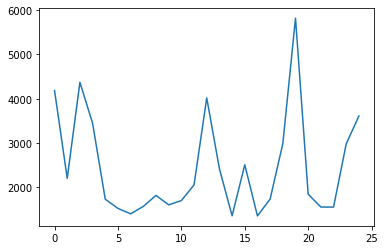

In [92]:
import matplotlib.pyplot as plt

plt.plot(loss_table)

In [98]:
model.eval()

test_dataset = PHMDataset(r'/content/drive/MyDrive/PHM-Tongji/data', ['c4'], train=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, num_workers=2)

label_table = []
predict_table = []

for inputs, labels in test_dataloader:
  inputs = inputs.float().to(device)
  labels = labels.float().to(device)

  outputs = model(inputs)

  label_table += labels.flatten().cpu().numpy().tolist()
  predict_table += outputs.flatten().cpu().detach().numpy().tolist()

labels = np.array(label_table)
predicted = np.array(predict_table)

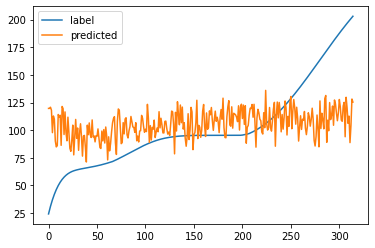

In [99]:
plt.plot(np.arange(len(label_table)), labels, label='label')
plt.plot(np.arange(len(label_table)), predicted, label='predicted')
plt.legend()

(array([ 21.,  18.,  31.,  26., 103.,  63.,  32.,  15.,   3.,   3.]),
 array([-111.02833557,  -94.3115799 ,  -77.59482422,  -60.87806854,
         -44.16131287,  -27.44455719,  -10.72780151,    5.98895416,
          22.70570984,   39.42246552,   56.13922119]),
 <a list of 10 Patch objects>)

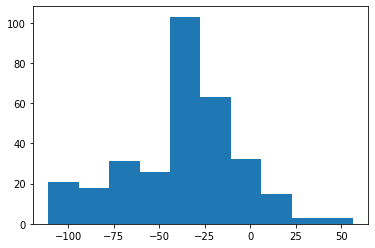

In [87]:
plt.hist(predicted - labels)

(array([ 84.,  53., 138.,  27.,   7.,   2.,   3.,   0.,   0.,   1.]),
 array([-0.35440418, -0.11570072,  0.12300273,  0.36170618,  0.60040963,
         0.83911309,  1.07781654,  1.31651999,  1.55522344,  1.7939269 ,
         2.03263035]),
 <a list of 10 Patch objects>)

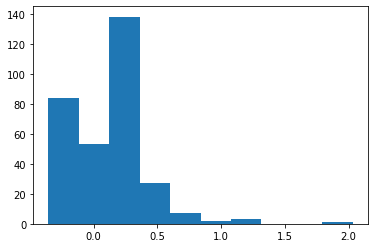

In [ ]:
plt.hist((predicted - labels) / labels)

In [ ]:
(np.array(label_table) - np.array(predict_table)).std()

33.73813358325385